# Unfolding Sr-90/Y-90 spectra from PIPS detector 

Created by Andrei R. Hanu

In [24]:
# Libraries to handle ROOT files
import ROOT
import root_numpy

# Theano
import theano
import theano.tensor

# Copy function
import copy

# NumPy
import numpy as np

# PyMC3
import pymc3 as pm

# Texttable
from texttable import Texttable

# Color palette library for Python
# How to choose a colour scheme for your data:
# http://earthobservatory.nasa.gov/blogs/elegantfigures/2013/08/05/subtleties-of-color-part-1-of-6/
import palettable

# Matplotlib - 2D plotting library
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec
#import seaborn.apionly as sns
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import Grid, AxesGrid

##########################################################################################
# Setting rcParams for publication quality graphs
fig_width_pt = 246.0                    # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # Width in inches
fig_height = fig_width*golden_mean      # Height in inches
fig_size =  [fig_width, fig_height]
fig_size =  np.array([7.3,4.2])*1.5
params = {'backend': 'pdf',
        'axes.labelsize': 12,
        'legend.fontsize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'xtick.major.size': 7,
        'xtick.major.width': 1,
        'xtick.minor.size': 3.5,
        'xtick.minor.width': 1.25,
        'ytick.major.size': 7,
        'ytick.major.width': 1.25,
        'ytick.minor.size': 3.5,
        'ytick.minor.width': 1.25,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Bitstream Vera Sans',
        'font.size': 11,
        'figure.figsize': fig_size}

# Update rcParams
rcParams.update(params)

In [25]:
# Threshold Energy, in keV, above which unfolding will occur
thld_e = 99.9
thld_e = 0.

## 1. Import the detector response matrix

In [26]:
# Load the ROOT file containing the response matrix for the detector
f_rspns = ROOT.TFile.Open('./TestData/Canberra PD450-15-500AM/Response Matrix/Canberra PD450-15-500AM PIPS.root')

# Retrieve the electron and gamma-ray energy migration matrices and source vectors (i.e. the true spectrum from which the response matrix was simulated)
# NOTE: Index 0 contains the bin values
#       Index 1 contains the bin edges
src_vec_e = np.asarray(root_numpy.hist2array(f_rspns.Get('Source Spectrum (Electron)'), 
                                             include_overflow=False, copy=True, return_edges=True))

src_vec_gam = np.asarray(root_numpy.hist2array(f_rspns.Get('Source Spectrum (Gamma)'), 
                                               include_overflow=False, copy=True, return_edges=True))

mig_mat_e = np.asarray(root_numpy.hist2array(f_rspns.Get('Energy Migration Matrix (Electron)'), 
                                             include_overflow=False, copy=True, return_edges=True))
    
mig_mat_gam = np.asarray(root_numpy.hist2array(f_rspns.Get('Energy Migration Matrix (Gamma)'), 
                                               include_overflow=False, copy=True, return_edges=True))

# Calculate the response matrices by normalizing the energy migration matrices by the source vectors
rspns_mat_e = copy.deepcopy(mig_mat_e)
rspns_mat_e[0] = np.nan_to_num(rspns_mat_e[0]/src_vec_e[0])
rspns_mat_gam = copy.deepcopy(mig_mat_gam)
rspns_mat_gam[0] = np.nan_to_num(rspns_mat_gam[0]/src_vec_e[0])

# Remove response matrix elements below threshold energy
rspns_mat_e[0] = np.delete(rspns_mat_e[0], np.where(rspns_mat_e[1][0] < thld_e), axis=0)
rspns_mat_e[0] = np.delete(rspns_mat_e[0], np.where(rspns_mat_e[1][0] < thld_e), axis=1)
rspns_mat_e[1] = np.delete(rspns_mat_e[1], np.where(rspns_mat_e[1][0] < thld_e), axis=1)
rspns_mat_gam[0] = np.delete(rspns_mat_gam[0], np.where(rspns_mat_gam[1][0] < thld_e), axis=0)
rspns_mat_gam[0] = np.delete(rspns_mat_gam[0], np.where(rspns_mat_gam[1][0] < thld_e), axis=1)
rspns_mat_gam[1] = np.delete(rspns_mat_gam[1], np.where(rspns_mat_gam[1][0] < thld_e), axis=1)

# Create a combined response matrix
rspns_mat_comb = copy.deepcopy(rspns_mat_e)
rspns_mat_comb[0] += rspns_mat_gam[0]

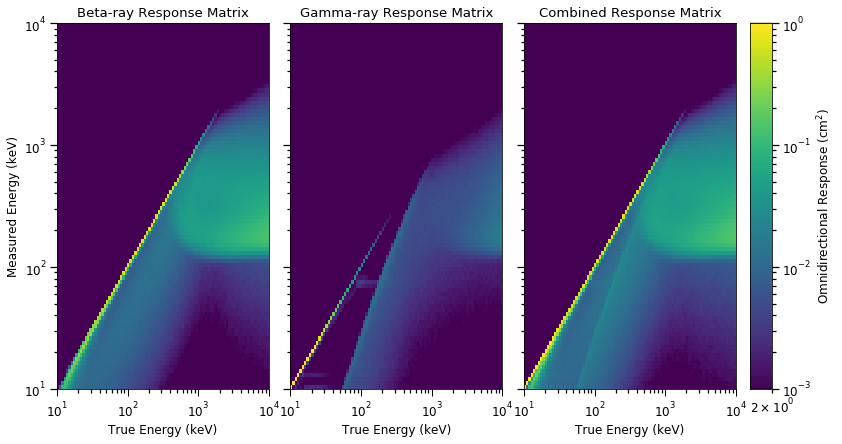

In [27]:
# Plot the energy migration matrix
fig_mig_mat = plt.figure()

ax_mig_mat = AxesGrid(fig_mig_mat, 111,
                      nrows_ncols=(1, 3),
                      axes_pad=0.3,
                      aspect=False,
                      label_mode = 'L',
                      cbar_mode='single',
                      cbar_location='right',
                      cbar_pad=0.2,
                      cbar_size = 0.3)

# Color map
cmap = palettable.matplotlib.Viridis_20.mpl_colormap
cmap.set_bad(cmap(0.))
cmap.set_over(cmap(1.))

# Response Limits 
rLimUp = np.ceil(np.abs(np.maximum(np.log10(rspns_mat_e[0].max()), 
                                   np.log10(rspns_mat_gam[0].max()))))
rLimLow = rLimUp/1E3

# Plot the response matrices
X, Y = np.meshgrid(rspns_mat_e[1][0], rspns_mat_e[1][1])
H0 = ax_mig_mat[0].pcolormesh(X, Y, rspns_mat_e[0].T, norm = colors.LogNorm(), cmap = cmap, linewidth = 0, rasterized = True) 

X, Y = np.meshgrid(rspns_mat_gam[1][0], rspns_mat_gam[1][1])
H1 = ax_mig_mat[1].pcolormesh(X, Y, rspns_mat_gam[0].T, norm = colors.LogNorm(), cmap = cmap, linewidth = 0, rasterized = True) 

X, Y = np.meshgrid(rspns_mat_comb[1][0], rspns_mat_comb[1][1])
H2 = ax_mig_mat[2].pcolormesh(X, Y, rspns_mat_comb[0].T, norm = colors.LogNorm(), cmap = cmap, linewidth = 0, rasterized = True) 

# Color limits for the plot
H0.set_clim(rLimLow, rLimUp)
H1.set_clim(rLimLow, rLimUp)
H2.set_clim(rLimLow, rLimUp)

# Colorbar     
from matplotlib.ticker import LogLocator
ax_mig_mat.cbar_axes[0].colorbar(H2, spacing = 'uniform')
ax_mig_mat.cbar_axes[0].set_yscale('log')
ax_mig_mat.cbar_axes[0].axis[ax_mig_mat.cbar_axes[0].orientation].set_label('Omnidirectional Response (cm$^2$)')

# Figure Properties
ax_mig_mat[0].set_xscale('log')
ax_mig_mat[0].set_yscale('log')
ax_mig_mat[0].set_ylabel('Measured Energy (keV)')
ax_mig_mat[0].set_xlabel('True Energy (keV)')
ax_mig_mat[0].set_title('Beta-ray Response Matrix')

ax_mig_mat[1].set_xscale('log')
ax_mig_mat[1].set_yscale('log')
ax_mig_mat[1].set_xlabel('True Energy (keV)')
ax_mig_mat[1].set_title('Gamma-ray Response Matrix')

ax_mig_mat[2].set_xscale('log')
ax_mig_mat[2].set_yscale('log')
ax_mig_mat[2].set_xlabel('True Energy (keV)')
ax_mig_mat[2].set_title('Combined Response Matrix')

# Fine-tune figure 
fig_mig_mat.tight_layout()

# Save the figure 
plt.savefig('Canberra PD450-15-500AM PIPS Response Matrix.jpg', bbox_inches="tight")

# Close the figure
plt.show(fig_mig_mat)

## 2. Import measured spectrum

In [28]:
# Load the ROOT file containing the measured spectrum
f_meas = ROOT.TFile.Open('./TestData/Canberra PD450-15-500AM/Sr90Y90/Sr90Y90_R_25_cm_Nr_100000000_ISO.root')

# Retrieve the measured spectrum
# NOTE: Index 0 contains the bin values
#       Index 1 contains the bin edges
meas_vec = np.asarray(root_numpy.hist2array(f_meas.Get('Detector Measured Spectrum'), 
                                            include_overflow=False, copy=True, return_edges=True))

truth_vec_e = np.asarray(root_numpy.hist2array(f_meas.Get('Source Spectrum (Electron)'),
                                               include_overflow=False, copy=True, return_edges=True))

truth_vec_gam = np.asarray(root_numpy.hist2array(f_meas.Get('Source Spectrum (Gamma)'),
                                                 include_overflow=False, copy=True, return_edges=True))

# Remove elements below threshold energy
meas_vec[0] = np.delete(meas_vec[0], np.where(meas_vec[1][0] < thld_e), axis=0)
meas_vec[1] = np.delete(meas_vec[1], np.where(meas_vec[1][0] < thld_e), axis=1)
truth_vec_e[0] = np.delete(truth_vec_e[0], np.where(truth_vec_e[1][0] < thld_e), axis=0)
truth_vec_e[1] = np.delete(truth_vec_e[1], np.where(truth_vec_e[1][0] < thld_e), axis=1)
truth_vec_gam[0] = np.delete(truth_vec_gam[0], np.where(truth_vec_gam[1][0] < thld_e), axis=0)
truth_vec_gam[1] = np.delete(truth_vec_gam[1], np.where(truth_vec_gam[1][0] < thld_e), axis=1)

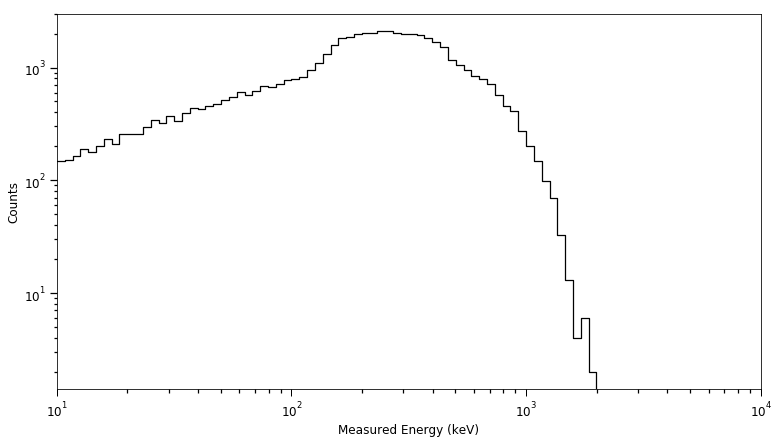

In [29]:
# Plot the measured spectrum
fig_meas_vec, ax_meas_vec = plt.subplots()

# Plot the raw spectrum
ax_meas_vec.plot(sorted(np.append(meas_vec[1][0][:-1], meas_vec[1][0][1:])),
                np.repeat(meas_vec[0], 2),
                lw=1.25,
                color='black',
                linestyle="-",
                drawstyle='steps')

# Figure properties
ax_meas_vec.set_xlabel('Measured Energy (keV)')
ax_meas_vec.set_ylabel('Counts')
ax_meas_vec.set_xlim(min(meas_vec[1][0]),max(meas_vec[1][0]))
ax_meas_vec.set_xscale('log')
ax_meas_vec.set_yscale('log')

# Fine-tune figure 
fig_meas_vec.tight_layout()

# Save the figure 
plt.savefig('Sr90Y90 - PIPS - Measured Spectrum', bbox_inches="tight")

## 3. Build the generative model
Generally, when a detector is exposed to a homogeneous radiation field, the relationship between the incoming particle fluence spectrum and the measured energy spectrum, $D(E)$, can be described by the following Fredholm integral equation of the first kind:

$$D\left(E\right) = \int_{0}^{\infty}R\left(E, E^{'}\right)\Phi\left(E^{'}\right)dE^{'} \ ,\ 0 \leq E \leq \infty$$

where $R\left(E, E^{'}\right)$ is a kernel describing the detector response in terms of the measured energy, $E$, and the true energy, $E^{'}$, of the incoming particle and $\Phi\left(E^{'}\right)$ is the incoming particle fluence spectrum.

Within the context of Bayesian inference, the above equation is often refered to as the generative model that describes how the measured data was generated when the detector was exposed to the radiation field. 

In [30]:
def asMat(x):
    '''
    Transform an array of doubles into a Theano-type array so that it can be used in the model
    '''
    return np.asarray(x,dtype=theano.config.floatX)

with pm.Model() as model:
    ''' 
    Define the upper and lower bounds of the uniform prior based on the measured data and the response matrix
    
    For an ideal radiation detector, the response matrix would a diagonal meaning that the measured spectrum would be an exact if not close approximation of the true particle spectrum incident on the detector. However, real detectors have response matrices which often have non-diagonal components due to physical interactions (e.g. compton scaterring) which result in only partial energy depositions. As a result, the measured spectrum is not an accurate representation of the true particle spectrum incident on the detector. Nevertheless, we can use the measured spectrum in combination with the response matrix to provide a good initial or "guess" spectrum for the Bayesian inference.
    '''
    
    lb_phi_e = np.zeros(rspns_mat_e[1][0].size - 1)
    ub_phi_e = np.zeros(rspns_mat_e[1][0].size - 1)
    lb_phi_gam = np.zeros(rspns_mat_gam[1][0].size - 1)
    ub_phi_gam = np.zeros(rspns_mat_gam[1][0].size - 1)
    
    # Get the upper and lower bounds from the combined response matrix
    t = Texttable()
    t.add_row(['True Energy', 'Min Response', 'Max Response', 'Min Phi (cm-2)', 'Max Phi (cm-2)'])
    for i in np.arange(rspns_mat_comb[1][0].size - 1):
        # Find the minimum and maximum non-zero response elements for each true energy
        index_min = np.argwhere(rspns_mat_comb[0][i,:] == np.min(rspns_mat_comb[0][i,:][np.nonzero(rspns_mat_comb[0][i,:])])).flatten()[0]
        index_max = np.argwhere(rspns_mat_comb[0][i,:] == rspns_mat_comb[0][i,:].max()).flatten()[0]
        
        # Calculate the lower and upper bounds on the prior based on the measured counts at the above
        # indeces and response elements
        min_phi = np.minimum(meas_vec[0][index_min], meas_vec[0][index_max])/rspns_mat_comb[0][i,index_max]
        max_phi = np.maximum(meas_vec[0][index_min], meas_vec[0][index_max])/rspns_mat_comb[0][i,index_min]
            
        # Update the bounds
        #lb_phi_e[i] = min_phi
        ub_phi_e[i] = max_phi
        #lb_phi_gam[i] = min_phi
        ub_phi_gam[i] = max_phi
        
        # Add it to the table for printout
        t.add_row(['{:.1f} kev'.format(rspns_mat_comb[1][0][i]),
                   '{:.2f} cm2 @ {:.1f} kev'.format(rspns_mat_comb[0][i,index_min], rspns_mat_comb[1][1][index_min]),
                   '{:.2f} cm2 @ {:.1f} kev'.format(rspns_mat_comb[0][i,index_max], rspns_mat_comb[1][1][index_max]),
                   '{:.3e} e-\n{:.3e} gam'.format(lb_phi_e[i], lb_phi_gam[i]),
                   '{:.3e} e-\n{:.3e} gam'.format(ub_phi_e[i], ub_phi_gam[i])])
        
    print t.draw()
    
    # Define the prior probability densities
    phi_e = pm.Uniform('phi_e', lower = lb_phi_e, upper = ub_phi_e, shape = (ub_phi_e.size))
    phi_gam = pm.Uniform('phi_gam', lower = lb_phi_gam, upper = ub_phi_gam, shape = (ub_phi_gam.size))

    # Define the generative models
    M = theano.tensor.dot(theano.shared(asMat(rspns_mat_e[0].T)), phi_e) + \
        theano.tensor.dot(theano.shared(asMat(rspns_mat_gam[0].T)), phi_gam)

    # Define the posterior probability function (PPF)
    PPF = pm.Poisson('PPF', mu = M, observed = theano.shared(meas_vec[0], borrow = False), shape = (meas_vec[0].size, 1))
    

+-------------+----------------+---------------+---------------+---------------+
| True Energy | Min Response   | Max Response  | Min Phi       | Max Phi       |
|             |                |               | (cm-2)        | (cm-2)        |
+-------------+----------------+---------------+---------------+---------------+
| 10.0 kev    | 2.47 cm2 @     | 2.47 cm2 @    | 0.000e+00 e-  | 5.952e+01 e-  |
|             | 10.0 kev       | 10.0 kev      | 0.000e+00 gam | 5.952e+01 gam |
+-------------+----------------+---------------+---------------+---------------+
| 10.8 kev    | 0.01 cm2 @     | 2.44 cm2 @    | 0.000e+00 e-  | 1.733e+04 e-  |
|             | 10.0 kev       | 10.8 kev      | 0.000e+00 gam | 1.733e+04 gam |
+-------------+----------------+---------------+---------------+---------------+
| 11.7 kev    | 0.02 cm2 @     | 2.37 cm2 @    | 0.000e+00 e-  | 6.747e+03 e-  |
|             | 10.8 kev       | 11.7 kev      | 0.000e+00 gam | 6.747e+03 gam |
+-------------+-------------

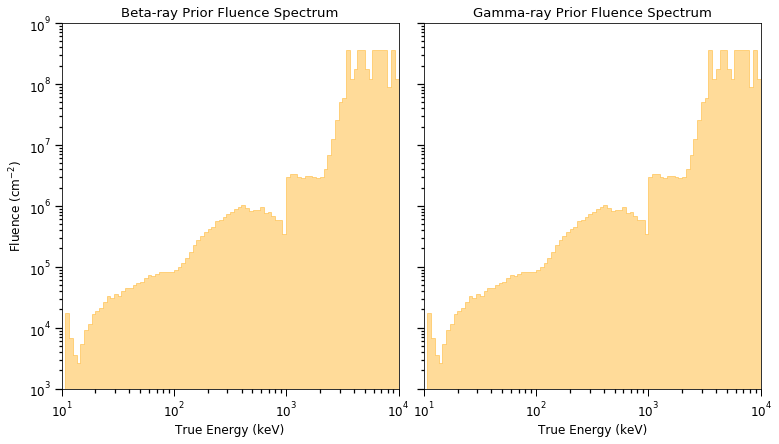

In [31]:
'''
Function to plot the prior fluence spectrum before performing multidimensional Bayesian unfolding
'''

# Create a figure and axis to plot the unfolded (aka. reconstructed) beta-ray and gamma-ray fluence spectra
fig_prior = plt.figure()

ax_prior = Grid(fig_prior, 
                111,
                nrows_ncols=(1, 2),
                axes_pad=(0.35, 0.35),
                add_all=True,
                label_mode = 'L')


# Plot the prior
ax_prior[0].fill_between(sorted(np.append(rspns_mat_e[1][0][:-1], rspns_mat_e[1][0][1:])), 
                         np.repeat(lb_phi_e, 2), 
                         np.repeat(ub_phi_e, 2),
                         color='orange',
                         alpha=0.4)

ax_prior[1].fill_between(sorted(np.append(rspns_mat_gam[1][0][:-1], rspns_mat_gam[1][0][1:])), 
                         np.repeat(lb_phi_gam, 2), 
                         np.repeat(ub_phi_gam, 2),
                         color='orange',
                         alpha=0.4)

# Find min and max y value for scaling the plot
y_lim_up = np.max([ub_phi_e, ub_phi_gam])
y_lim_up = 10**np.ceil(np.abs(np.log10(y_lim_up)))
y_lim_down = y_lim_up/1E6

# Figure properties
ax_prior[0].set_xlabel('True Energy (keV)')
ax_prior[0].set_ylabel('Fluence (cm$^{-2}$)')
ax_prior[0].set_xlim(min(rspns_mat_e[1][0]), max(rspns_mat_e[1][0]))
ax_prior[0].set_ylim(y_lim_down, y_lim_up)
ax_prior[0].set_xscale('log')
ax_prior[0].set_yscale('log')
ax_prior[0].set_title('Beta-ray Prior Fluence Spectrum')

ax_prior[1].set_xlabel('True Energy (keV)')
ax_prior[1].set_xlim(min(rspns_mat_gam[1][0]),max(rspns_mat_gam[1][0]))
ax_prior[1].set_ylim(y_lim_down, y_lim_up)
ax_prior[1].set_xscale('log')
ax_prior[1].set_yscale('log')
ax_prior[1].set_title('Gamma-ray Prior Fluence Spectrum')

# Fine-tune figure 
fig_prior.tight_layout()

# Save the figure 
plt.savefig('Sr90Y90 - PIPS - Prior Fluence Spectrum', bbox_inches="tight")

## 4. Sample the posterior 

In [32]:
'''
Function to sample the posterior distribution using the ADVI variational inference algorithm.
'''
iterations = 1000000
samples = 100000
with model:
    from pymc3.variational.callbacks import CheckParametersConvergence
    
    # Use the maximum a posteriori as a good starting point
    start = pm.find_MAP(model = model)
    
    print '\nInfering the posterior distribution using ADVI'
    approxADVI = pm.variational.inference.fit(n=iterations,
                                              method='advi',
                                              start=start,
                                              callbacks=[CheckParametersConvergence(every=1000, 
                                                                                    diff='absolute', 
                                                                                    tolerance = 5E-2)])

    # Draw sample from ADVI fit
    trace = approxADVI.sample(draws=samples)

logp = -2,696.5, ||grad|| = 0.075616: 100%|██████████| 601/601 [00:00<00:00, 1167.28it/s]     



Infering the posterior distribution using ADVI


Average Loss = 3,317:   6%|▋         | 62981/1000000 [01:05<16:20, 955.29it/s]  
Convergence archived at 63000
Interrupted at 62,999 [6%]: Average Loss = 3,305.9


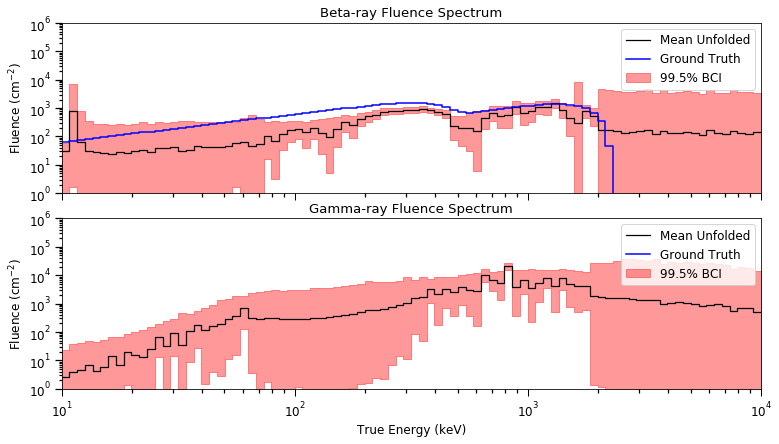

In [33]:
'''
Function to plot the reconstructed fluence spectrum
'''

# Create a Pandas dataframe of summary information from the sampling
df_reco = pm.summary(trace, alpha=0.005)

# Create a figure and axis to plot the unfolded (aka. reconstructed) beta-ray and gamma-ray fluence spectra
fig_reco_vec = plt.figure()

ax_reco_vec = Grid(fig_reco_vec, 
                    111,
                    nrows_ncols=(2, 1),
                    axes_pad=(0.35, 0.35),
                    add_all=True,
                    label_mode = 'L')

# Plot the unfolded spectrum
ax_reco_vec[0].plot(sorted(np.append(rspns_mat_e[1][0][:-1], rspns_mat_e[1][0][1:])),
                    np.repeat(df_reco[df_reco.index.str.startswith('phi_e')]['mean'], 2),
                    lw=1.25,
                    color='black',
                    linestyle="-",
                    drawstyle='steps',
                    label='Mean Unfolded')

ax_reco_vec[0].fill_between(sorted(np.append(rspns_mat_e[1][0][:-1], rspns_mat_e[1][0][1:])), 
                            np.repeat(df_reco[df_reco.index.str.startswith('phi_e')]['hpd_0.25'], 2), 
                            np.repeat(df_reco[df_reco.index.str.startswith('phi_e')]['hpd_99.75'], 2),
                            color='red',
                            alpha=0.4,
                            label='99.5% BCI')

ax_reco_vec[1].plot(sorted(np.append(rspns_mat_gam[1][0][:-1], rspns_mat_gam[1][0][1:])),
                    np.repeat(df_reco[df_reco.index.str.startswith('phi_gam')]['mean'], 2),
                    lw=1.25,
                    color='black',
                    linestyle="-",
                    drawstyle='steps',
                    label='Mean Unfolded')

ax_reco_vec[1].fill_between(sorted(np.append(rspns_mat_gam[1][0][:-1], rspns_mat_gam[1][0][1:])), 
                            np.repeat(df_reco[df_reco.index.str.startswith('phi_gam')]['hpd_0.25'], 2), 
                            np.repeat(df_reco[df_reco.index.str.startswith('phi_gam')]['hpd_99.75'], 2),
                            color='red',
                            alpha=0.4,
                            label='99.5% BCI')

# Plot the truth spectrum (if known)
ax_reco_vec[0].plot(sorted(np.append(truth_vec_e[1][0][:-1], truth_vec_e[1][0][1:])),
                    np.repeat(truth_vec_e[0], 2),
                    lw=1.5,
                    color='blue',
                    linestyle="-",
                    drawstyle='steps',
                    label='Ground Truth')

ax_reco_vec[1].plot(sorted(np.append(truth_vec_gam[1][0][:-1], truth_vec_gam[1][0][1:])),
                    np.repeat(truth_vec_gam[0], 2),
                    lw=1.5,
                    color='blue',
                    linestyle="-",
                    drawstyle='steps',
                    label='Ground Truth')

# Find min and max y value for scaling the plot
y_lim_up = np.max([truth_vec_e[0].max(),
                   truth_vec_gam[0].max(),
                   df_reco[df_reco.index.str.startswith('phi_e')]['hpd_99.75'].max(),
                   df_reco[df_reco.index.str.startswith('phi_gam')]['hpd_99.75'].max()])
y_lim_up = 10**np.ceil(np.abs(np.log10(y_lim_up)))
y_lim_up = 1E6
y_lim_down = y_lim_up/1E6

# Figure properties
ax_reco_vec[0].set_xlabel('True Energy (keV)')
ax_reco_vec[0].set_ylabel('Fluence (cm$^{-2}$)')
ax_reco_vec[0].set_xlim(min(rspns_mat_e[1][0]), max(rspns_mat_e[1][0]))
ax_reco_vec[0].set_ylim(y_lim_down, y_lim_up)
ax_reco_vec[0].set_xscale('log')
ax_reco_vec[0].set_yscale('log')
ax_reco_vec[0].set_title('Beta-ray Fluence Spectrum')
ax_reco_vec[0].legend(loc='best')

ax_reco_vec[1].set_xlabel('True Energy (keV)')
ax_reco_vec[1].set_ylabel('Fluence (cm$^{-2}$)')
ax_reco_vec[1].set_xlim(min(rspns_mat_gam[1][0]),max(rspns_mat_gam[1][0]))
ax_reco_vec[1].set_ylim(y_lim_down, y_lim_up)
ax_reco_vec[1].set_xscale('log')
ax_reco_vec[1].set_yscale('log')
ax_reco_vec[1].set_title('Gamma-ray Fluence Spectrum')
ax_reco_vec[1].legend(loc='best')

# Fine-tune figure 
fig_reco_vec.tight_layout()

# Save the figure 
plt.savefig('Sr90Y90 - PIPS - Unfolded Fluence Spectrum', bbox_inches="tight")